In [1]:
import scanpy
import anndata
import matplotlib
from matplotlib import pyplot
import hdf5plugin
import numpy
import scvelo
import seaborn
import pandas
import warnings
import os
import tensorflow
import unitvelo

# Configure TensorFlow to use the legacy Keras interface
os.environ["TF_USE_LEGACY_KERAS"] = "True"

2026-02-19 14:27:50.404837: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-19 14:27:51.953090: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-19 14:27:55.829482: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


(Running UniTVelo 0.2.5.2)
2026-02-19 13:27:57


In [2]:
# Ignore deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

In [3]:
# Check if GPU is available
velo = unitvelo.config.Configuration()
velo.R2_ADJUST = True
velo.IROOT = None
velo.FIT_OPTION = '1'
velo.N_TOP_GENES = 2104
velo.FILTER_CELLS = False
velo.USE_RAW = True # Do not redo normalization
if tensorflow.config.list_physical_devices("GPU"):
    print("Using GPU")
    velo.GPU = 0
else:
    print("Using CPU")
    velo.GPU = -1

Using GPU


In [4]:
# Read input file
working_directory = "Data/"
adata = scanpy.read_h5ad(working_directory+"/clustered_anndata.h5ad")

# Or read saved file for further analysis
# adata = scanpy.read_h5ad(working_directory+"/velocity_unitvelo.h5ad")

print(adata)

AnnData object with n_obs × n_vars = 16146 × 2104
    obs: 'leiden_0.6', 'leiden_0.2_c6', 'sample', 'latent_time'
    var: 'gene_ids', 'fit_likelihood'
    uns: 'leiden_0.2_c6_colors', 'leiden_0.6_colors', 'neighbors', 'sample_colors'
    obsm: 'X_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'matrix', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'


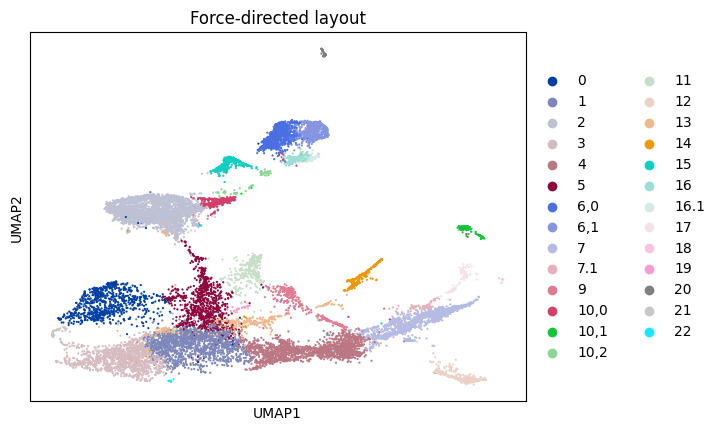

In [5]:
# Plot UMAP

scanpy.pl.embedding(basis='umap', adata=adata, color="leiden_0.2_c6", size=10, title="Force-directed layout")

In [6]:
# UniTVelo does not handle csr_matrices properly, so convert those to dense matrices

adata.layers["unspliced"] = adata.layers["unspliced"].toarray()
adata.layers["spliced"] = adata.layers["spliced"].toarray()

Only 94 genes were selected from UnitVelo's selection process. To include more genes, self.VGENES = "raw" and self.R2_ADJUST = False can be used.

UniTVElo crashed due to video memory shortage.

------> Manully Specified Parameters <------
N_TOP_GENES:	2104
USE_RAW:	True
------> Model Configuration Settings <------
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Current working dir is /home/avesta/m26_losu/pv_neuron_reprogramming.
Results will be stored in res folder
computing neighbors
    finished (0:00:27) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)

# of velocity genes 355 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 317 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 94 (Criterion: genes have reads in more than 5% of total cells)
Using GPU card: 0


I0000 00:00:1771507735.115742   26037 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43681 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:17:00.0, compute capability: 8.6
Loss (Total): 23983.573, (Spliced): 12484.116, (Unspliced): 11499.457:   7%|▋         | 800/12000 [01:43<25:28,  7.33it/s]       I0000 00:00:1771507843.499378   26037 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x614600e15fe0
Loss (Total): 17028.789, (Spliced): 8581.531, (Unspliced): 8447.258: 100%|█████████▉| 11999/12000 [29:25<00:00,  2.12it/s]  

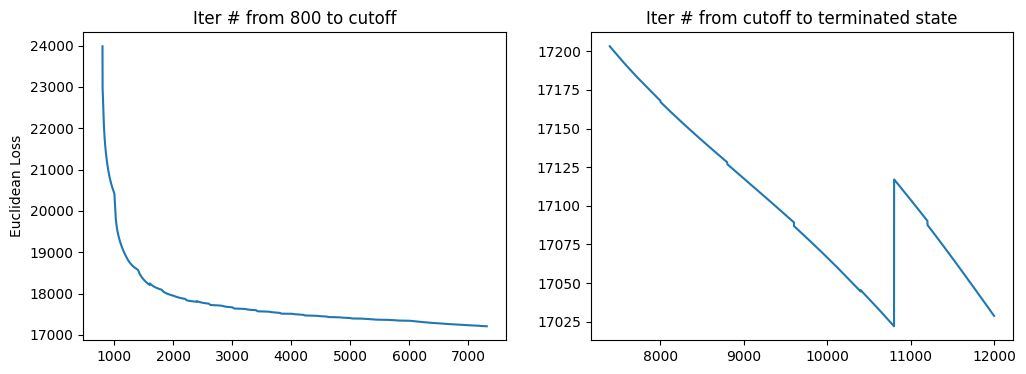

Loss (Total): 17028.789, (Spliced): 8581.531, (Unspliced): 8447.258: 100%|█████████▉| 11999/12000 [31:03<00:00,  6.44it/s]

Total loss 17022.052, vgene loss 17028.789


  0%|          | 0/16146 [00:00<?, ?cells/s]

/home/avesta/m26_losu/miniconda3/envs/unitvelo/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=26037) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


In [7]:
# Train UniTVelo model
adata = unitvelo.run_model(adata, "leiden_0.2_c6", config_file=velo, normalize=False)

In [8]:
print(adata)

AnnData object with n_obs × n_vars = 16146 × 2104
    obs: 'leiden_0.6', 'leiden_0.2_c6', 'sample', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_ids', 'fit_likelihood', 'velocity_gamma', 'velocity_r2', 'scaling', 'velocity_genes', 'fit_vars', 'fit_varu', 'fit_gamma', 'fit_beta', 'fit_offset', 'fit_a', 'fit_t', 'fit_h', 'fit_intercept', 'fit_loss', 'fit_llf', 'fit_sr2', 'fit_ur2'
    uns: 'leiden_0.2_c6_colors', 'leiden_0.6_colors', 'neighbors', 'sample_colors', 'temp', 'pca', 'datapath', 'label', 'base_function', 'basis', 'velocity_params', 'par_names', 'loss', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_umap', 'X_pca', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'matrix', 'spliced', 'unspliced', 'velocity', 'velocity_u', 'Mu_scale'
    obsp: 'connectivities', 'distances'


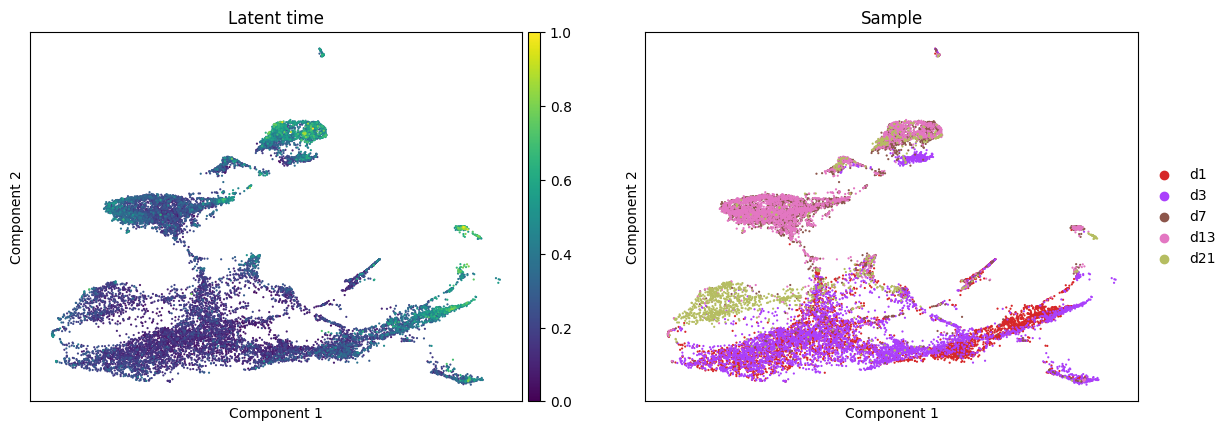

In [10]:
# Plot latent time
axis_list = scanpy.pl.embedding(basis='umap', adata=adata, color=["latent_time", "sample"], size=10, title=["Latent time", "Sample"], show=False)
for axis in axis_list:
    axis.set_xlabel("Component 1")
    axis.set_ylabel("Component 2")
pyplot.show()

In [11]:
# Velocity cosine correlations
scvelo.tl.velocity_graph(adata, vkey="velocity", n_jobs=16)

  0%|          | 0/16146 [00:00<?, ?cells/s]

/home/avesta/m26_losu/miniconda3/envs/unitvelo/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=26037) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


/home/avesta/m26_losu/miniconda3/envs/unitvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/miniconda3/envs/unitvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/miniconda3/envs/unitvelo/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/avesta/m26_losu/

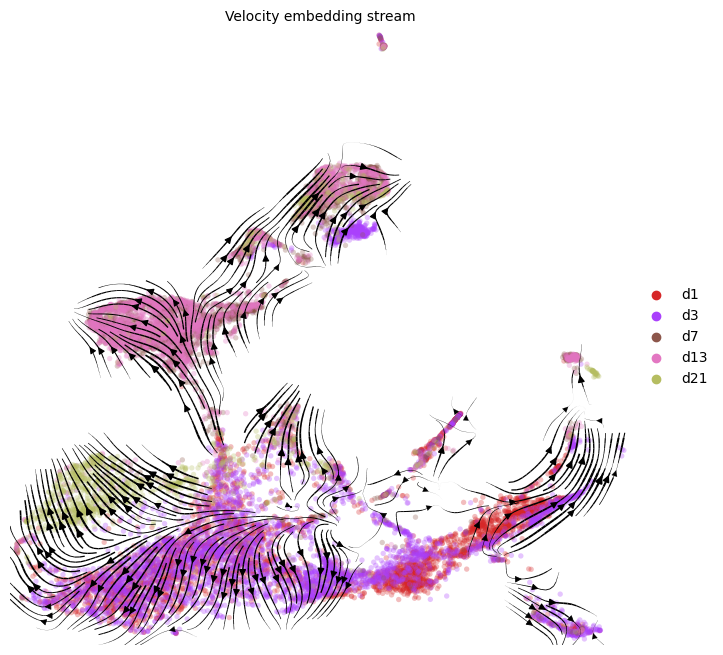

In [12]:
scvelo.pl.velocity_embedding_stream(adata, vkey="velocity", basis="umap", color="sample", legend_loc="right", figsize=(8,8), title="Velocity embedding stream", density=4)

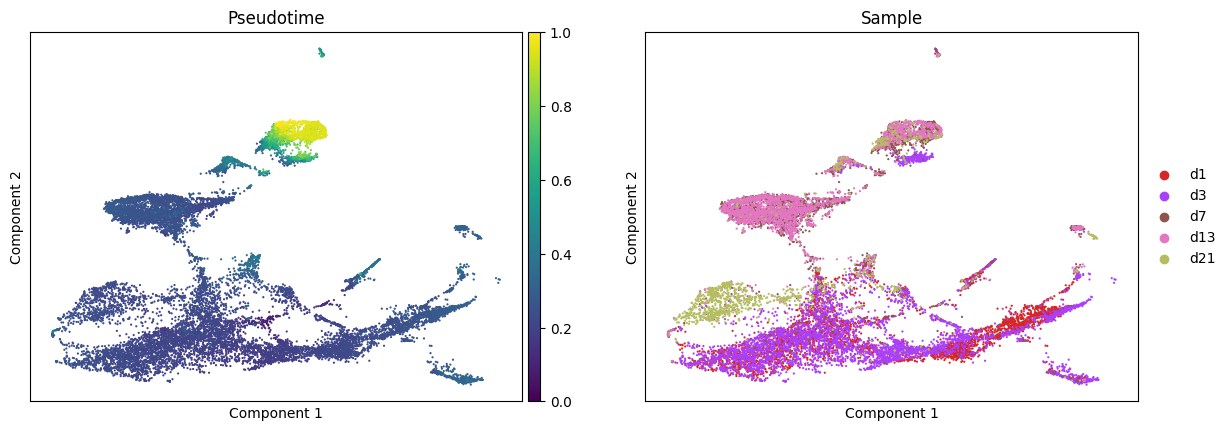

In [13]:
# Plot pseudotime
axis_list = scanpy.pl.embedding(basis="umap", adata=adata, color=["velocity_pseudotime", "sample"], size=10, title=["Pseudotime", "Sample"], show=False)
for axis in axis_list:
    axis.set_xlabel("Component 1")
    axis.set_ylabel("Component 2")
pyplot.show()

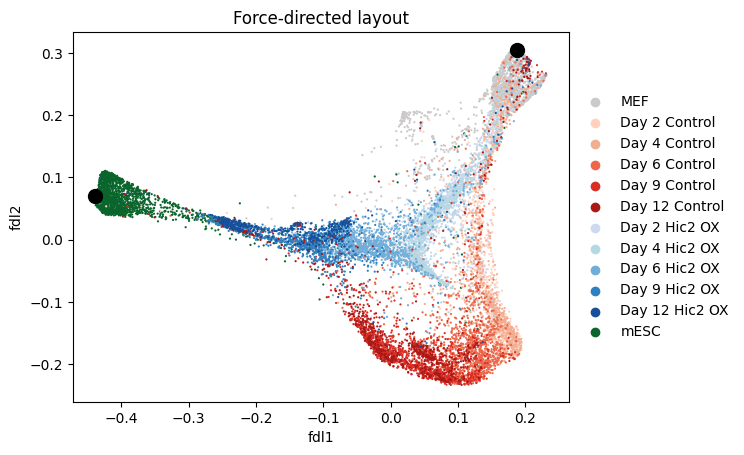

In [15]:
# Find good root and end cells

# Find root
root_filter = (adata.obs["group"]=="MEF")
# Use MEF cell with largest UMAP2, ignoring outliers with >10
root_index = numpy.argmax(adata[root_filter].obsm["X_fdl"][:,1])
root_barcode = adata[root_filter].obs.index[root_index]
adata.obs["manual_root"] = False
adata.obs["manual_root"].loc[root_barcode] = True

# Find end
end_filter = adata.obs["group"]=="mESC"
# Use mESC cell with smallest UMAP1
end_index = numpy.argmin(adata[end_filter].obsm["X_fdl"][:,0])
end_barcode = adata[end_filter].obs.index[end_index]
adata.obs["manual_end"] = False
adata.obs["manual_end"].loc[end_barcode] = True

ax = scanpy.pl.embedding(basis='fdl', adata=adata, color="sample", size=10, title="Force-directed layout", show=False)

# Plot UMAP
ax.scatter(*adata[adata.obs["manual_end"]].obsm["X_fdl"][0], marker="o", s=100, color="black")
ax.scatter(*adata[adata.obs["manual_root"]].obsm["X_fdl"][0], marker="o", s=100, color="black")
ax.yaxis.set_major_locator(matplotlib.ticker.AutoLocator())
ax.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())

pyplot.show()

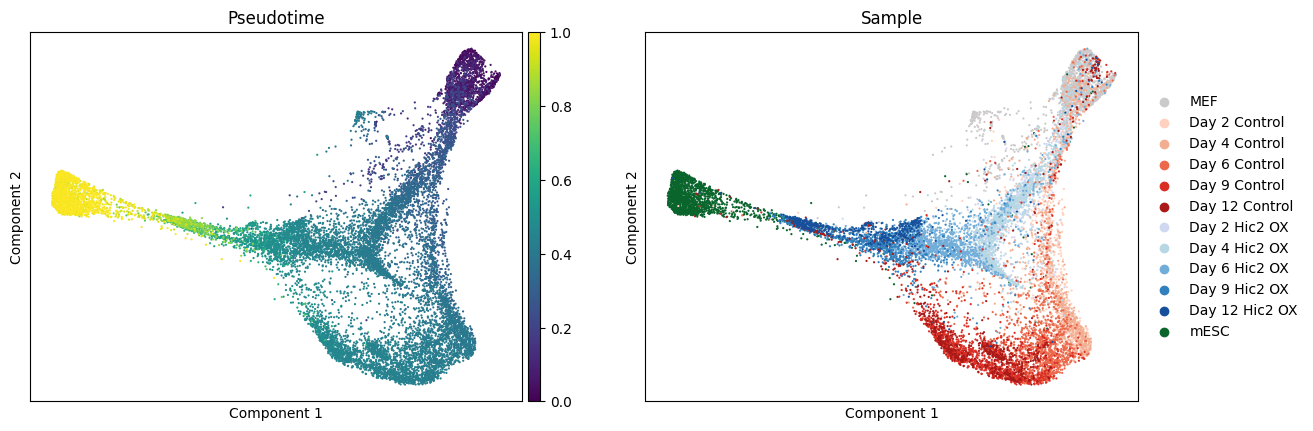

In [ ]:
# Recalculate pseudotime with manual root and end
global_root_index = numpy.argmax(adata.obs.index == root_barcode)
global_end_index = numpy.argmax(adata.obs.index == end_barcode)

scvelo.tl.velocity_pseudotime(adata, root_key=global_root_index, end_key=global_end_index, vkey="velocity")

# Plot velocities colored by latent time
axis_list = scanpy.pl.embedding(basis='fdl', adata=adata, color=["velocity_pseudotime", "sample"], size=10, title=["Pseudotime", "Sample"], show=False)
for axis in axis_list:
    axis.set_xlabel("Component 1")
    axis.set_ylabel("Component 2")
pyplot.show()

In [14]:
# Save adata object
adata.write_h5ad(
    working_directory+"/velocity_unitvelo.h5ad",
    compression=hdf5plugin.FILTERS["zstd"]
)